# Great Energy Predictor - Exploratory Data Analysis
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

## Section I: Dependencies and data

### Dependencies

In [70]:
import gc
import os
import zipfile
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import src.utils as udf

In [71]:
# Plot settings
sns.set(rc={'figure.figsize': (16, 4),
            'font.size': 14})

### Create data directory

In [72]:
# Create data directory
data_path = '../data/'
udf.mkdir(data_path)

# Create subdirectory for raw data
data_path += 'raw/'
udf.mkdir(data_path)

### Download data from Kaggle

##### Download manually
1. Create a Kaggle account [here](https://www.kaggle.com/account/login?phase=startRegisterTab&returnUrl=%2F)
2. Download the data manually [here](https://www.kaggle.com/c/ashrae-energy-prediction/data)
3. Unzip the .zip file and move all extracted files into the `data/raw/` directory created in the code cell above

##### Download programatically
1. Create a Kaggle account [here](https://www.kaggle.com/account/login?phase=startRegisterTab&returnUrl=%2F)
2. Navigate to `Account` in the menu and scroll down to `API`
3. Click `Create New API Token` - this downloads a json file called `kaggle.json` that contains the API credentials
4. If Kaggle API is not already installed, use `pip install kaggle` or `conda install kaggle` in the terminal
5. Uncomment and run the code cell below (may take a while to run)

Source: https://github.com/Kaggle/kaggle-api

In [73]:
# # Move Kaggle credentials into ~/.kaggle/
# !mv ~/Downloads/kaggle.json ~/.kaggle/kaggle.json

# # Remove read permission for other users
# !chmod 600 ~/.kaggle/kaggle.json

# # Download zipped data from Kaggle
# !kaggle competitions download -c ashrae-energy-prediction
# zip_file = 'ashrae-energy-prediction.zip'

# # Unzip the data into the raw data directory
# with zipfile.ZipFile(zip_file, 'r') as f:
#     f.extractall(data_path)
    
# # Delete zip file
# !rm $zip_file
# del zip_file

### Import data

In [74]:
# Meter data
meter = pd.read_csv(data_path + 'train.csv', parse_dates=['timestamp'])
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int64         
 1   meter          int64         
 2   timestamp      datetime64[ns]
 3   meter_reading  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 616.9 MB


In [75]:
# Reduce memory in meter data
meter = udf.reduce_mem_usage(meter)
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    uint16        
 1   meter          uint8         
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), uint16(1), uint8(1)
memory usage: 289.2 MB


In [76]:
# Weather data
weather = pd.read_csv(data_path + 'weather_train.csv', parse_dates=['timestamp'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int64         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float64       
 3   cloud_coverage      70600 non-null   float64       
 4   dew_temperature     139660 non-null  float64       
 5   precip_depth_1_hr   89484 non-null   float64       
 6   sea_level_pressure  129155 non-null  float64       
 7   wind_direction      133505 non-null  float64       
 8   wind_speed          139469 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


In [77]:
# Reduce memory in weather data
weather = udf.reduce_mem_usage(weather)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  uint8         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float32       
 3   cloud_coverage      70600 non-null   float32       
 4   dew_temperature     139660 non-null  float32       
 5   precip_depth_1_hr   89484 non-null   float32       
 6   sea_level_pressure  129155 non-null  float32       
 7   wind_direction      133505 non-null  float32       
 8   wind_speed          139469 non-null  float32       
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 4.9 MB


In [78]:
# Building data
building = pd.read_csv(data_path + 'building_metadata.csv')
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [79]:
# Reduce memory in building data
building = udf.reduce_mem_usage(building)
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   uint8  
 1   building_id  1449 non-null   uint16 
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   uint32 
 4   year_built   675 non-null    float32
 5   floor_count  355 non-null    float32
dtypes: float32(2), object(1), uint16(1), uint32(1), uint8(1)
memory usage: 32.7+ KB


In [80]:
del data_path
gc.collect()

182

## Section II: Meter EDA

### Convert units for site 0 meter types 0 and 1

The meter readings of meter types 0 and 1 of site 0 were not converted in the meter data. We will be converting all meter 0 (electricity) readings in site 0 to kWh and all meter 1 (chilledwater) readings in site 0 to tons to be consistent with the rest of the data.

Source: https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261

In [81]:
# Add site column to meter dataframe
meter = pd.merge(meter, building[['site_id', 'building_id']], on='building_id', how='left')

# Positive electric readings in site 0 (in kBTU)
meter[(meter.site_id == 0) & (meter.meter == 0) & (meter.meter_reading > 0)].head(3)

,building_id,meter,timestamp,meter_reading,site_id
45,46,0,2016-01-01,53.239700,0
72,74,0,2016-01-01,43.001301,0
91,93,0,2016-01-01,52.420601,0


In [82]:
# Convert site 0 electric readings to kWh: 1 kBTU * 0.2931 = 1kWh
meter = udf.convert_readings(meter, site_num=0, meter_num=0, convert_from='kbtu', convert_to='kwh')
meter[(meter.site_id == 0) & (meter.meter == 0) & (meter.meter_reading > 0)].head(3)

,building_id,meter,timestamp,meter_reading,site_id
45,46,0,2016-01-01,15.604556,0
72,74,0,2016-01-01,12.603682,0
91,93,0,2016-01-01,15.364478,0


In [83]:
# Chilled water readings in site 0 (in kBTU)
meter[(meter.site_id == 0) & (meter.meter == 1)].head(3)

,building_id,meter,timestamp,meter_reading,site_id
3172286,7,1,2016-02-29 09:00:00,1857.260010,0
3172289,9,1,2016-02-29 09:00:00,590.945007,0
3172294,13,1,2016-02-29 09:00:00,1224.099976,0


In [84]:
# Convert site 0 chilled water readings to tons: 1 kBTU/hr * 0.0833 = 1 ton (refridgeration)
meter = udf.convert_readings(meter, site_num=0, meter_num=1, convert_from='kbtu', convert_to='ton')
meter[(meter.site_id == 0) & (meter.meter == 1)].head(3)

,building_id,meter,timestamp,meter_reading,site_id
3172286,7,1,2016-02-29 09:00:00,154.709763,0
3172289,9,1,2016-02-29 09:00:00,49.225719,0
3172294,13,1,2016-02-29 09:00:00,101.967529,0


### Duplicated observations and missing values in meter data

In [85]:
# Duplicated observations
meter.duplicated(subset=['building_id', 'meter', 'timestamp']).sum()

0

In [86]:
# Missing values
meter.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
site_id          0
dtype: int64

In [87]:
# Missing timestamps
timestamp_count = meter.groupby(['building_id', 'meter']).count()
n_meters = timestamp_count.shape[0] # number of different meters in the dataset
n_timestamps = 366 * 24 # every meter should have this many readings
(n_meters * n_timestamps) - meter.shape[0]

689820

In [88]:
# Summary of missing readings
udf.print_missing_readings(meter)

Buildings: 1449
Total meters: 2380
Electricity meters: 1413
Chilledwater meters: 498
Steam meters: 324
Hotwater meters: 145

Buildings with meter(s) with missing readings: 1085 (74%)
Total meters with missing readings: 1660 (69%)
Electricity meters with missing readings: 990 (70%)
Chilledwater meters with missing readings: 347 (69%)
Steam meters with missing readings: 221 (68%)
Hotwater meters with missing readings: 102 (70%)


### Explore meter readings

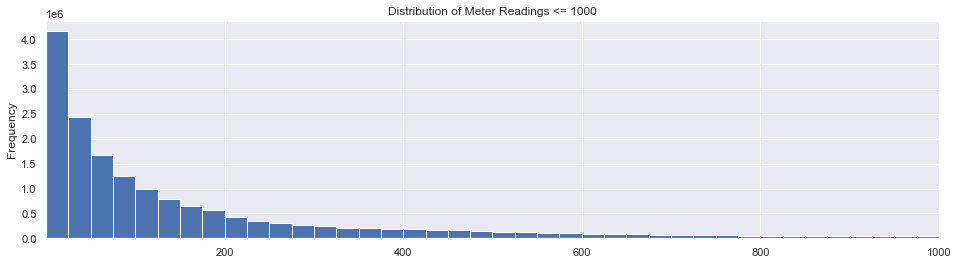

In [89]:
# Distribution of meter readings less than or equal to 1000
meter_lte1000 = meter[(meter.meter_reading > 0) & (meter.meter_reading <= 1000)]
meter_lte1000.meter_reading.plot(kind='hist', bins=40, title='Distribution of Meter Readings <= 1000')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

In [90]:
# Check high meter readings
high_readings = meter[meter.meter_reading >= 1e6]
print(high_readings.shape[0])
high_readings.head(3)

3067


,building_id,meter,timestamp,meter_reading,site_id
1534,1099,2,2016-01-01 00:00:00,3241630.0,13
3830,1099,2,2016-01-01 01:00:00,3241630.0,13
13015,1099,2,2016-01-01 05:00:00,1896620.0,13


In [91]:
# Check buildings and meters with high readings
print('Buildings:', high_readings.building_id.unique())
print('Meters:', high_readings.meter.unique())

Buildings: [1099]
Meters: [2]


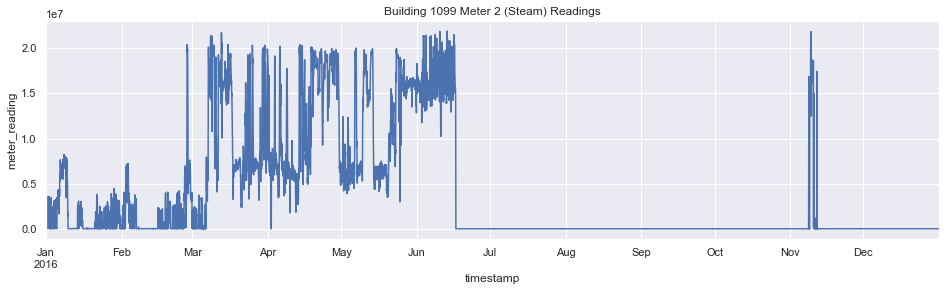

In [92]:
# Check building 1099 meter 2
b1099m2 = meter[(meter.building_id == 1099) & (meter.meter == 2)].set_index('timestamp')
b1099m2.meter_reading.plot(title='Building 1099 Meter 2 (Steam) Readings')
plt.ylabel('meter_reading')
plt.show()

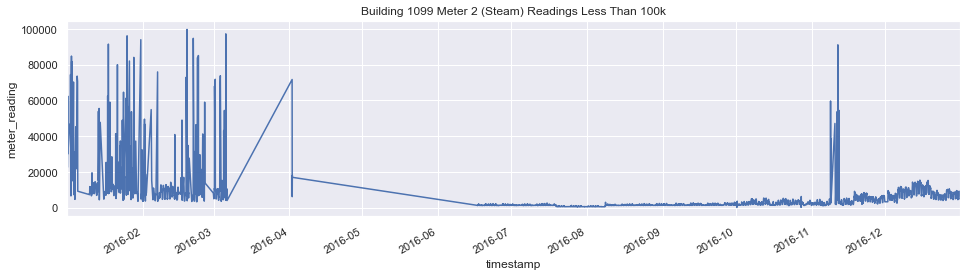

In [93]:
# See readings less than or equal to 100,000
b1099m2_lte100k = b1099m2[b1099m2.meter_reading <= 1e5].meter_reading
b1099m2_lte100k.plot(title='Building 1099 Meter 2 (Steam) Readings Less Than 100k')
plt.ylabel('meter_reading')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

### Outlier meter readings

All of the high readings are coming from meter 2 of building 1099. This could be due to the meter malfunctioning or the data being corrupted but either way, we will be dropping these readings.

In [94]:
# Set outlier threshold
lower, upper = udf.get_outlier_threshold(meter, 'meter_reading', stat='iqr', multiplier=50)
lower, upper

(-11390.863775253296, 11654.689975738525)

In [95]:
# Count outliers based on threshold
outliers = meter[meter.meter_reading > upper].shape[0]
print(f'{outliers} outliers ({round(outliers * 100 / meter.shape[0], 2)}%)')

77229 outliers (0.38%)


In [96]:
# Remove outliers
meter = meter[meter.meter_reading <= upper]
meter.shape

(20138871, 5)

In [97]:
del timestamp_count, n_meters, n_timestamps, meter_lte1000, b1099m2, b1099m2_lte100k, \
    high_readings, lower, upper, outliers
gc.collect()

14213

### Explore meters

In [ ]:
# Add meter type string in a new column
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
meter['meter_type'] = meter.meter.map(meter_types)

# How many buildings have a certain meter?
meter_type_count = meter.groupby('meter_type').building_id.nunique().sort_values()
meter_type_count

In [ ]:
# Number of buildings with each meter type
meter_type_count.plot.barh(title='Number of Buildings with Each Meter Type')
plt.ylabel('Meter')
plt.xlabel('Number of buildings')
plt.show()

In [ ]:
# How many buildings have a certain number of meters?
meter_count = meter.groupby('building_id').meter.nunique().value_counts().sort_values()
meter_count

In [ ]:
# Number of buildings with n meters
meter_count.plot.barh(title='Number of Buildings with n Meters')
plt.ylabel('Number of meters in the building (n)')
plt.xlabel('Number of buildings')
plt.show()

In [ ]:
# Number of meter readings from each building
meter.groupby('building_id').timestamp.count().plot(title='Number of Meter Readings from Each Building')
plt.ylabel('Number of meter readings')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

##### Meter summary
- Most buildings have only 1 meter type and and only 13 buildings actually have all 4 meter types
- Almost all buildings have an electricity meter, followed by chilledwater, steam, then hotwater (in count)

### Sample meter readings from each meter type

In [ ]:
# Meter readings from each meter type
meter_groups = [meter[meter.meter == m].building_id.unique() for m in range(4)]
udf.plot_readings(meter, meter_groups, resample='d', start=0, end=1)
plt.show()

The plots show a lot of 0-readings, which are likely missing data. Chilled water meter readings are highest in the summer months, while steam and hot water meter readings are highest in the winter months, which makes sense.

In [ ]:
# Extract time components from timestamp
time_comps = ['dayofyear', 'month', 'day', 'dayofweek', 'hour']
meter = udf.extract_dt_components(meter, time_comps)
meter.head(3)

In [ ]:
# Meter readings by weekday
udf.plot_readings(meter, meter_groups, groupby=['dayofweek', 'hour'],
                  start=25, end=26, ticks=range(0, 7 * 24, 12))
plt.show()

##### Daily meter readings
- Readings from all 4 meter types oscillate between day and night
- Electricity meter readings reach their peak around noon and their minimum around midnight
- The low electricity usage in the weekend suggests that building is likely an office or other business that is closed on weekends
- Steam and hot water meter readings reach their peak in the early morning and their minimum in the evening hours
- Chilled water meter readings show an oscillation pattern opposite from steam and hot water meters

In [ ]:
# Meter readings by hour
udf.plot_readings(meter, meter_groups, groupby=['hour'], start=50, end=51, ticks=range(24))
plt.show()

These plots take a closer look at the daily oscillation in meter readings. The patterns are the same as described above.

### Monthly average meter readings of each site

In [ ]:
# Electric meters only
e_meter = meter[meter.meter == 0]

# Electric meter readings by site (readings from site 7 are on a greater scale)
udf.pivot_elec_readings(e_meter, pivot_col='site_id', freq='m', cols_to_sep=[7], add_to_title=' by Site')

In [ ]:
# Check average building size in site 7
building.groupby('site_id').square_feet.mean()

In [ ]:
del meter_types, meter_type_count, meter_count, meter_groups, time_comps, e_meter
gc.collect()

Site 7 buildings are much larger (greater square footage) on average than all other sites. That could explain some, if not all, of the difference in meter reading scale. This will require more investigation during preprocessing.

## Section III: Weather EDA

### Duplicated observations and missing values in weather data

In [ ]:
# Duplicated observations
weather.duplicated(subset=['site_id', 'timestamp']).sum()

In [ ]:
# Missing values
weather.isnull().sum()

In [ ]:
# Missing timestamps
(16 * 366 * 24) - weather.shape[0]

### Explore weather

In [ ]:
# Value distributions
udf.hist_subplots(weather, range(2, 9))
plt.show()

In [ ]:
# Daily weather in site 4
weather4 = udf.get_site(weather, 4, time_idx=True).resample('d').mean()
weather4.plot(subplots=True, figsize=(16, 28))
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Extract hour from timestamp
weather = udf.extract_dt_components(weather, ['hour'])

# Site 8 hourly weather
weather8 = udf.get_site(weather, 8).groupby('hour').mean()
weather8.plot(subplots=True, figsize=(16, 28))
plt.xlim(0, 23)
plt.xticks(range(24), rotation=0)
plt.show()

In [ ]:
# Hourly temperature from all sites
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp.plot(figsize=(16, 6), xticks=range(24), title='Hourly air temperature by site')
plt.ylabel('air temperature')
plt.xlim(0, 23)
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.show()

### Convert UTC to local time

Sites:
- 0 - Orlando, Florida (GMT-5)
- 1 - United Kingdom (GMT+0)
- 2 - Arizona (GMT-7)
- 3 - U.S. Eastern Time Zone (GMT-5)
- 4 - Northern California (GMT-8)
- 5 - United Kingdom (GMT+0)
- 6 - U.S. Eastern Time Zone (GMT-5)
- 7 - Southeastern Canada (GMT-5)
- 8 - Orlando, Florida (GMT-5)
- 9 - Texas (GMT-6)
- 10 - U.S. Mountain Time Zone (GMT-7)
- 11 - Southeastern Canada (GMT-5)
- 12 - Dublin, Ireland (GMT+0)
- 13 - Minnesota (GMT-6)
- 14 - U.S. Eastern Time Zone (GMT-5)
- 15 - U.S. Eastern Time Zone (GMT-5)

Sources:
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698
- https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature
- https://www.kaggle.com/datadugong/locate-better-cities-by-weather-temp-fill-nans

In [ ]:
# Offsets for timezones
timezones = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

# Convert UTC to local time
weather = udf.to_local_time(weather, timezones)
weather['hour'] = weather.timestamp.dt.hour

# Hourly temperature from all sites
airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')
airtemp.plot(figsize=(16, 6), xticks=range(24), title='Hourly air temperature by site')
plt.ylabel('air temperature')
plt.xlim(0, 23)
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.show()

In [ ]:
# Air temperature by site
sns.jointplot(data=weather, x='air_temperature', y='site_id')
plt.show()

In [ ]:
del weather4, weather8, airtemp, timezones
gc.collect()

## Section IV: Building EDA

### Duplicated observations and missing values in building data

In [ ]:
# Duplicated observations
building.duplicated(subset=['building_id']).sum()

In [ ]:
# Missing values
building.isnull().sum()

### Explore buildings

In [ ]:
# Value distributions
udf.hist_subplots(building, range(3, 6))
plt.show()

In [ ]:
# Number of buildings in each site
building.groupby('site_id').building_id.count().plot.bar(title='Number of buildings in each site')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Average values by site
bldg_avg_by_site = building.drop('building_id', axis=1).groupby('site_id').mean()
bldg_avg_by_site

In [ ]:
# Plot average square footage and floor count by site
plot_titles = ['Average %s in each site' % col for col in ['square feet', 'floor count']]
bldg_avg_by_site.drop('year_built', axis=1).plot.bar(subplots=True, figsize=(16, 8), title=plot_titles,
                                              legend=False, color=['r', 'g'])
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Plot average year-built by site
bldg_avg_by_site.year_built.plot.bar(title='Average year built of buildings in each site', ylim=(1900, 2000))
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Number of each type of building
bldg_use_counts = building.groupby('primary_use').building_id.count().sort_values()
bldg_use_counts.plot.barh(figsize=(16, 6), title='Number of each type of building')
plt.show()

In [ ]:
# Number of each type of building in each site
bldg_use_by_site = pd.pivot_table(building, index='site_id', columns='primary_use', values='building_id',
                           aggfunc='count', fill_value=0)
bldg_use_by_site

In [ ]:
# Plot number of each type of building in each site
bldg_use_by_site.plot.bar(stacked=True, figsize=(16, 6), title='Number of each type of building in each site')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(0.9, -0.15), ncol=4, fancybox=True)
plt.show()

In [ ]:
# Average values by primary use
bldg_avg_by_use = building.drop(['site_id', 'building_id'], axis=1).groupby('primary_use').mean()
bldg_avg_by_use

In [ ]:
# Subplot titles
plot_titles = ['Average %s for each type' % col for col in ['square feet', 'floor count']]

# Average square footage and floor count by primary use
bldg_avg_by_use.drop('year_built', axis=1).plot.bar(subplots=True, figsize=(16, 8), title=plot_titles,
                                             legend=False, color=['c', 'm'])
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Average year-built by primary uuse
bldg_avg_by_use.year_built.plot.bar(figsize=(16, 4), title='Average year built of buildings for each type',
                             ylim=(1900, 2020), color='y')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
del bldg_avg_by_site, plot_titles, bldg_use_counts, bldg_use_by_site, bldg_avg_by_use
gc.collect()

## Section V: Summary

### Save dataframes

In [ ]:
# Create new subdirectory in data directory
output_path = '../data/from_eda/'
udf.mkdir(output_path)

In [ ]:
# Save meter data
meter.to_pickle(f'{output_path}meter.pkl')
pd.read_pickle(f'{output_path}meter.pkl').head(2)

In [ ]:
# Save weather data
weather.drop('hour', axis=1).to_pickle(f'{output_path}weather.pkl')
pd.read_pickle(f'{output_path}weather.pkl').head(2)

In [ ]:
# Save building data
building.to_pickle(f'{output_path}building.pkl')
pd.read_pickle(f'{output_path}building.pkl').head(2)

In [ ]:
del output_path
gc.collect()